In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SOURCE = 'drive/MyDrive/archive/resized_images/'
df = pd.read_csv('drive/MyDrive/archive/resized_images/main.csv') # Might have a few extra images due to dataset bug.
df

,filename,label
0,00000.png,norwich
1,00001.png,norwich
2,00002.png,norwich
3,00003.png,norwich
4,00004.png,norwich
...,...,...
20075,20075.png,wolves
20076,20076.png,wolves
20077,20077.png,wolves
20078,20078.png,wolves


In [ ]:
# Let's read in the images, takes between 1 - 5 minutes
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map 

def read_image(filename):
  return np.asarray(Image.open(SOURCE+filename))

X = process_map(read_image, df['filename'], max_workers=20) # We read using multithreading to make this process faster

<ipython-input-4-43c71baeb240>:8: TqdmWarning: Iterable length 20080 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  X = process_map(read_image, df['filename'], max_workers=20)


  0%|          | 0/20080 [00:00<?, ?it/s]

In [ ]:
X = np.asarray(X)
X.shape

(20080, 28, 28, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, df['label'], train_size=0.8, random_state=0, shuffle=True, stratify=df['label'])
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=0, shuffle=True, stratify=y_test)
print('Train size:', x_train.shape)
print('Validation size:', x_val.shape)
print('Test size:', x_test.shape)

Train size: (16064, 28, 28, 3)
Validation size: (2008, 28, 28, 3)
Test size: (2008, 28, 28, 3)


In [ ]:
# Let's go from RGBA -> RGB and fix the image size to be the same
# Takes a PIL image as input
def fix_image(img, k=28):
    img = img.resize([k,k])
    return img.convert('RGB')
  

In [ ]:
import torch
import tensorflow as tf

# Constructs the model
def build_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,3)),
        tf.keras.layers.Rescaling(scale=1./255), # Normailze image
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(20)
  ])

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 rescaling (Rescaling)       (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 128)               301184    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 20)                660       
                                                                 
Total params: 312,180
Trainable params: 312,180
Non-trai

In [ ]:
# Complie the model and print out layer information; done for debugging purposes
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 28, 28, 3) <dtype: 'float32'>
(None, 20) <dtype: 'float32'>
flatten_1 (None, 28, 28, 3) float32
rescaling_1 (None, 2352) float32
dense_4 (None, 2352) float32
dense_5 (None, 128) float32
dense_6 (None, 64) float32
dense_7 (None, 32) float32


[None, None, None, None, None, None]

In [ ]:
x_train = np.asarray(list(x_train)).astype('float32') # Convert these vectors to be of type float32
x_val = np.asarray(x_val).astype('float32')

# Labels given by dataset
LABELS = {'arsenal':0, 'aston-villa':1, 'brentford':2, 'brighton':3, 'burnley':4, 'chelsea':5, 'crystal-palace':6, 'everton':7, 'leeds':8, 'leicester-city':9, 'liverpool':10, 'manchester-city':11, 'manchester-united':12, 'newcastle':13, 'norwich':14, 'southampton':15, 'tottenham':16, 'watford':17, 'west-ham':18, 'wolves':19}

In [ ]:
y_train = list(map(LABELS.get, y_train)) # Use the numeric label to form the y-vector

In [ ]:
y_val = np.asarray(list(map(LABELS.get, y_val)))
y_val

array([ 4,  9, 12, ...,  5, 13, 13])

In [ ]:
y_train = np.asarray(y_train)
print(y_train)

# Train the model
model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

[ 6 10 13 ...  0 16 17]
Epoch 1/20
502/502 [==============================] - 4s 3ms/step - loss: 0.4941 - accuracy: 0.8698 - val_loss: 0.0644 - val_accuracy: 0.9846
Epoch 2/20
502/502 [==============================] - 1s 3ms/step - loss: 0.0497 - accuracy: 0.9877 - val_loss: 0.0362 - val_accuracy: 0.9900
Epoch 3/20
502/502 [==============================] - 1s 3ms/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.0190 - val_accuracy: 0.9955
Epoch 4/20
502/502 [==============================] - 1s 3ms/step - loss: 0.0306 - accuracy: 0.9908 - val_loss: 0.0225 - val_accuracy: 0.9915
Epoch 5/20
502/502 [==============================] - 1s 3ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0418 - val_accuracy: 0.9846
Epoch 6/20
502/502 [==============================] - 1s 3ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0419 - val_accuracy: 0.9910
Epoch 7/20
502/502 [==============================] - 1s 3ms/step - loss: 0.0294 - accuracy: 0.9909 - val_loss: 0.0170 - val

In [ ]:
x_test = np.asarray(list(x_test)).astype('float32')
y_test = np.asarray(list(map(LABELS.get, y_test)))

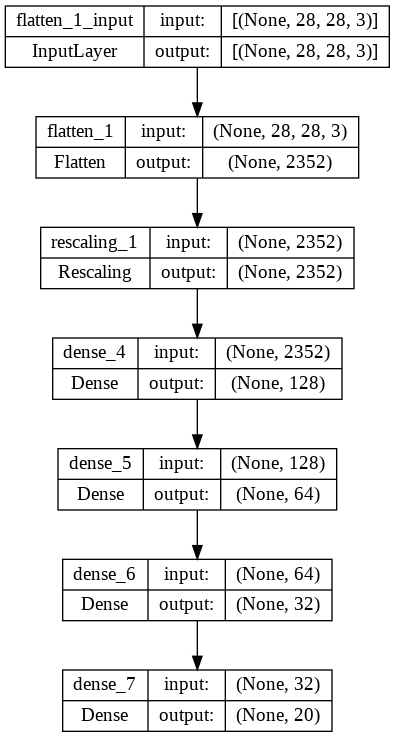

In [ ]:
# Print model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Test the model
test_results = model.evaluate(x_test, y_test, verbose=0)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

Test results - Loss: 0.022533433511853218 - Accuracy: 0.9960159659385681%


In [ ]:
# Print confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, accuracy_score
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:', conf_mat)
print(y_test.shape)


63/63 [==============================] - 0s 2ms/step
Confusion matrix: [[100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  99   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0  99   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0  99   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 105   0   3   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0
    0

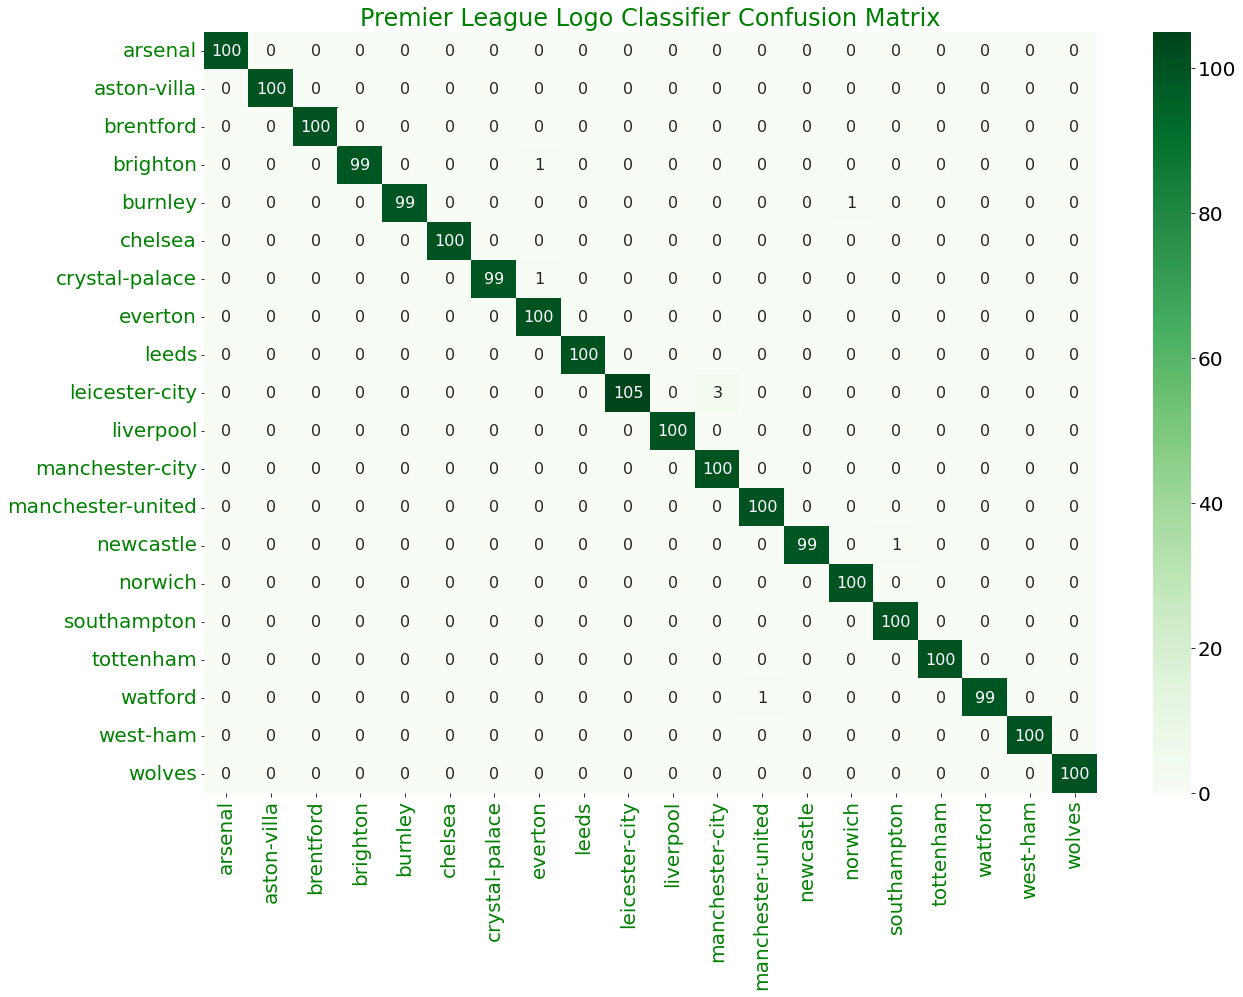

In [ ]:
# Graph the confusion matrix

import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_mat, index = list(LABELS.keys()),
                  columns = list(LABELS.keys()))
plt.figure(figsize = (20,14))
plt.ticklabel_format(style='plain')
plt.title("Premier League Logo Classifier Confusion Matrix", color="green")
plt.rcParams['font.size'] = 20
plt.tick_params(labelcolor="g")
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Greens')


2/2 [==============================] - 0s 5ms/step


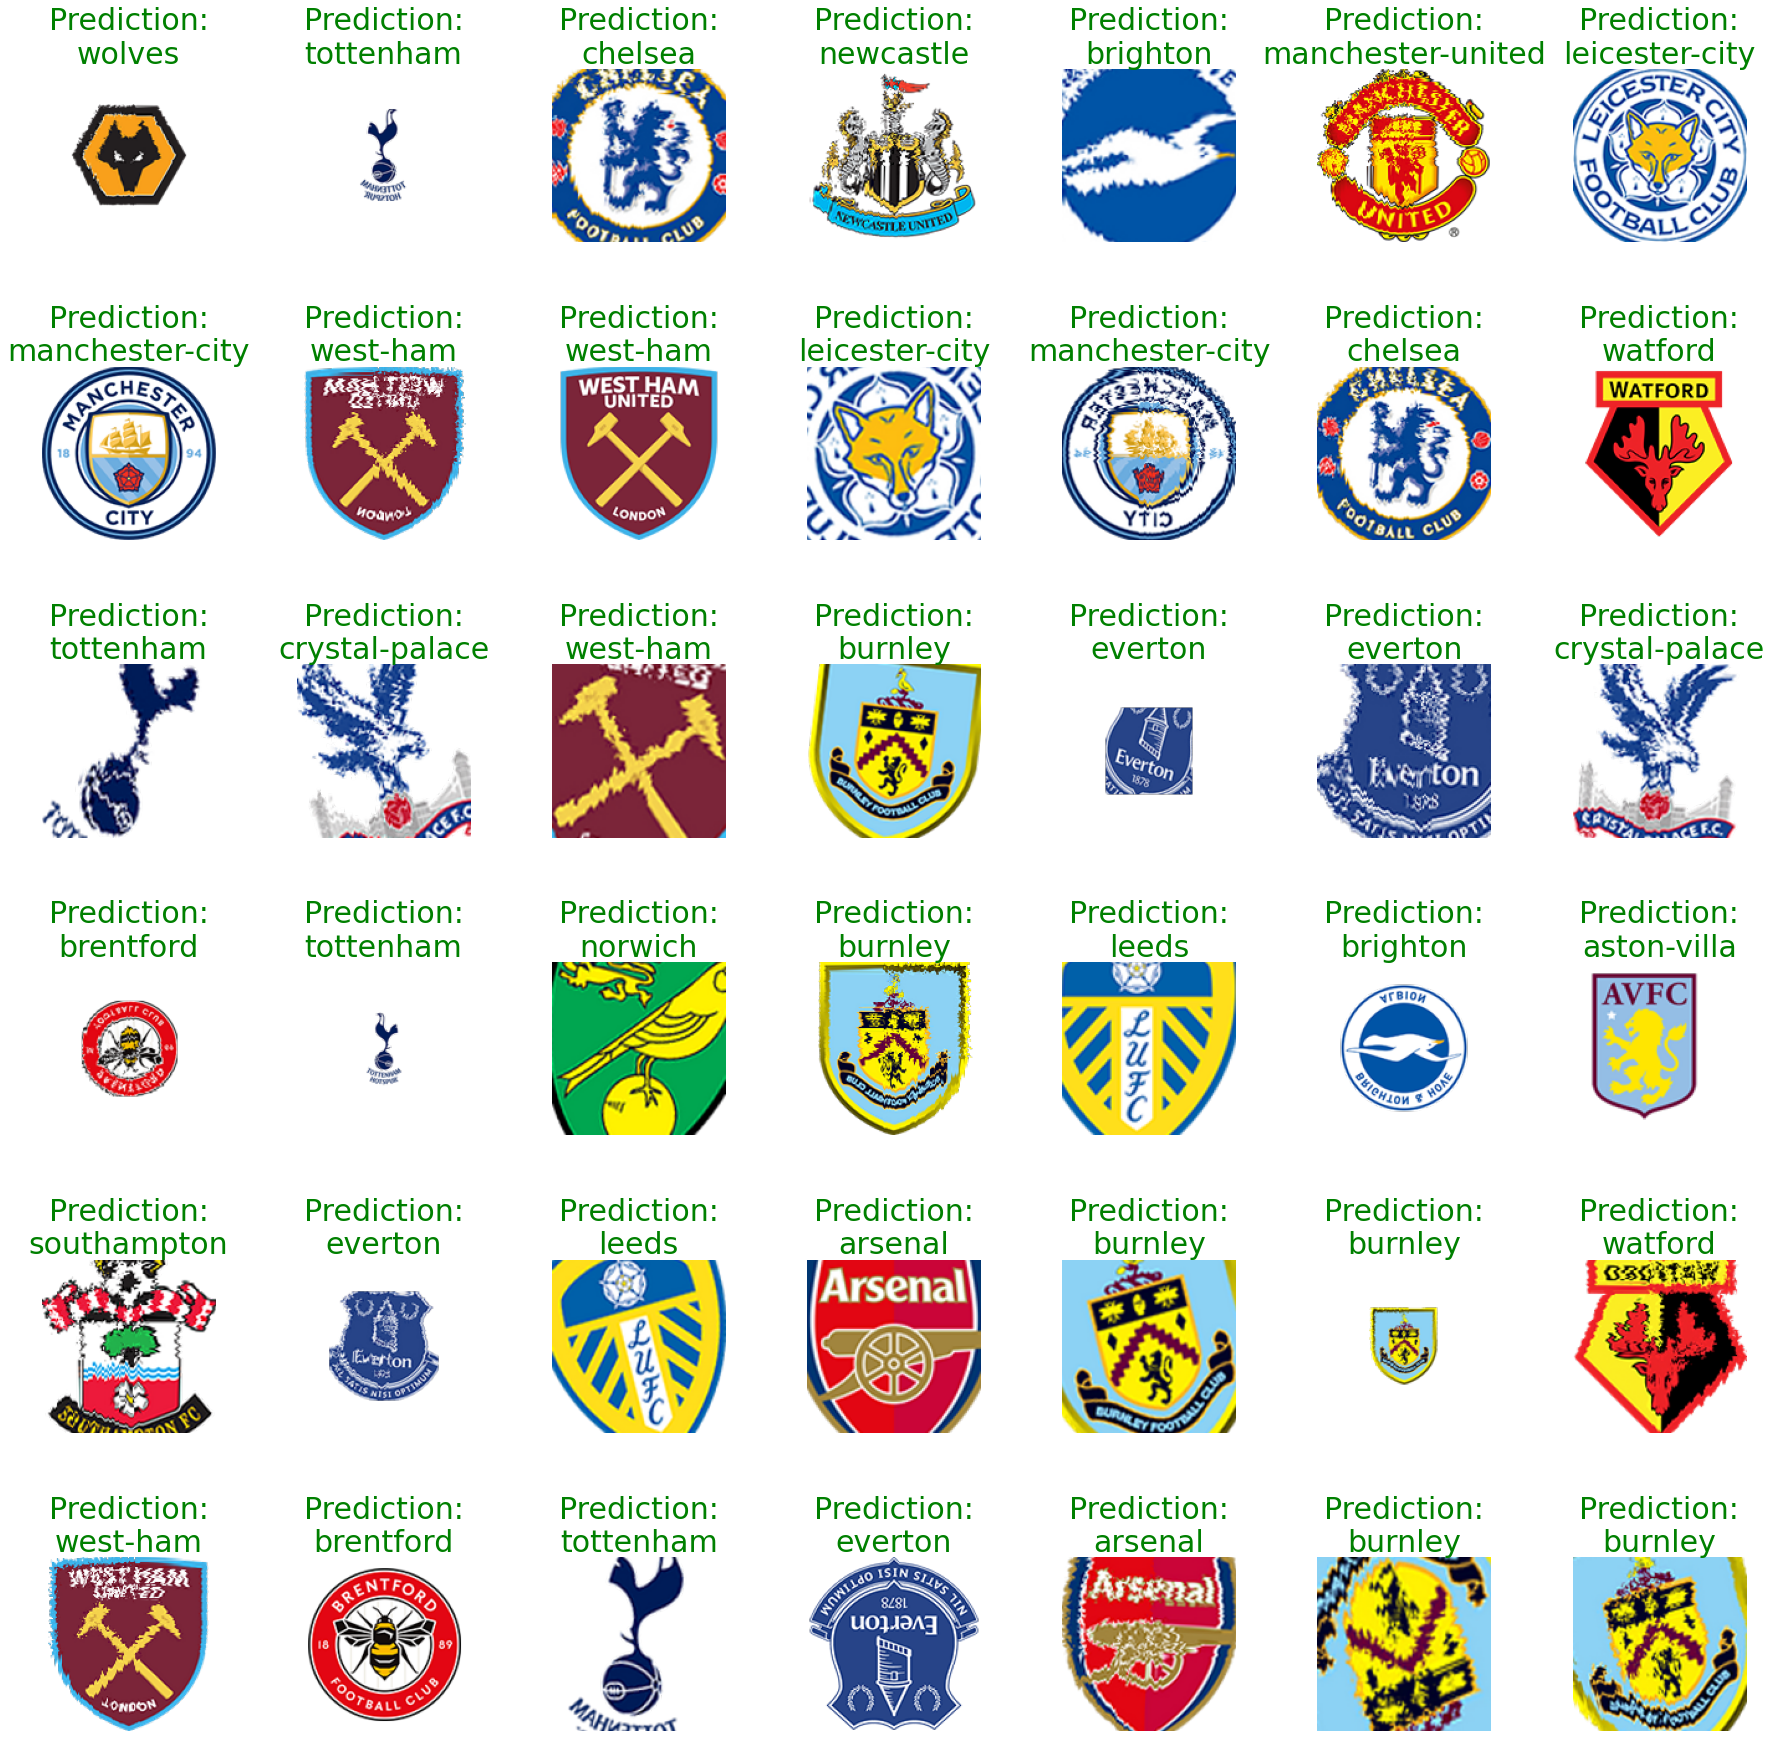

CORRECT: 42/42


In [ ]:
import random

# batch of PIL Images of any size to class label
# returns a list of strings of predictions
def predict_images(model, image_batch):
    labels = list(LABELS.keys())
    fixed_images = list(map(fix_image, image_batch)) # Resize the shape to the correct size
    fixed_images = np.array(list(map(np.asarray, fixed_images)))
    prediction = np.argmax(model.predict(fixed_images), axis=1) # Get predictions from model (choose label which has highest probablitity according to the output layer of the model)
    return [labels[p] for p in prediction] # Get corresponding class label from the numeric predictions

# Returns a list of PIL Images and their associated correct labels
def get_random_image_batch(filepath, batch_size=1):
    image_paths = []
    for team in os.listdir(filepath):
        if 'DS_' not in team:
            image_paths += [(os.path.join(team,file), team) for file in os.listdir(os.path.join(filepath, team)) if '.DS' not in file]
    random_data = random.sample(image_paths, k=batch_size) # Select random files
    random_images = [Image.open(os.path.join(filepath, image[0])) for image in random_data]
    correct_labels = [x[1] for x in random_data]
    return random_images, correct_labels

# Let's predict a batch of 42 random images to see if our model works!
ROWS = 6
COLS = 7
DATAPATH = 'drive/MyDrive/archive/input/english-premier-league-logo-detection-20k-images/epl-logos-big/epl-logos-big'
random_batch, correct_labels = get_random_image_batch(DATAPATH, ROWS * COLS)    
predicted_labels = predict_images(model, random_batch)
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(25, 25))
fig.tight_layout(pad=0.7)
num_correct = 0
for i in range(ROWS * COLS):
    plt.subplot(ROWS, COLS, i+1)
    plt.imshow(random_batch[i])
    num_correct += 1 if predicted_labels[i] == correct_labels[i] else 0
    fc = 'green' if predicted_labels[i] == correct_labels[i] else 'red' # Green font if its the correct prediction; red otherwise
    plt.title('Prediction:\n' + predicted_labels[i], fontsize=30, color=fc)
    plt.axis('off')
plt.show()
print(f'CORRECT: {num_correct}/{ROWS*COLS}')

In [ ]:
# Let's iterate through all images and convert them to 28x28
# Time how long it takes!
# SOURCE PATH - absolute path to epl-logos-big
# WRITE PATH - absolute/relative path to directory where file will be written
def write_resized_images(SOURCE_PATH, WRITE_PATH):
  import os, time
  import pandas as pd

  i = 0
  files = []
  labels = []
  start = time.time()
  for team in os.listdir(SOURCE_PATH):
    if 'DS_Store' not in team:
      for image in os.listdir(SOURCE_PATH + "/" + team):
          if 'DS_Store' not in image:
            imagefilepath = SOURCE_PATH + "/" + team + "/" + image
            img = fix_image(Image.open(imagefilepath))
            new_filename = '{0:05d}.png'.format(i)
            img.save(os.path.join(WRITE_PATH, new_filename))
            files.append(new_filename)
            labels.append(team)
            i += 1
  end = time.time()
  print('Time:', end-start, 'seconds.')
  tmp = {'filename':files, 'label':labels}
  pd.DataFrame(tmp).to_csv(os.path.join(WRITE_PATH,'main.csv'),index=False)
SOURCE_PATH = 'drive/MyDrive/archive/input/english-premier-league-logo-detection-20k-images/epl-logos-big/epl-logos-big'
WRITE_PATH = 'drive/MyDrive/archive/resized_images'
# write_resized_images(SOURCE_PATH, WRITE_PATH)

Authors: Israel Kwilinski, Joshua Du, Ben Schnoor